# Capstone Regression Project

Pedro J. Salinas [pedrojsalinas@gmail.com](mailto:pedrojsalinas@gmail.com)

## Loading the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
df = pd.read_csv("../data/02_modeling.csv")

In [3]:
df.shape

(29182, 26)

In [4]:
df.head(5)

,selldate,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,...,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,address,lat,long,yr_old,city
0,2022-05-24,675000.0,4,1.0,1180,7140,1.0,NO,NO,NO,...,0,0,40,1969,0,"2102 Southeast 21st Court, Renton, Washington ...",47.461975,-122.19052,53,Renton
1,2021-12-13,920000.0,5,2.5,2770,6703,1.0,NO,NO,YES,...,1570,0,240,1950,0,"11231 Greenwood Avenue North, Seattle, Washing...",47.711525,-122.35591,71,Seattle
2,2021-09-29,311000.0,6,2.0,2880,6156,1.0,NO,NO,NO,...,1580,0,0,1956,0,"8504 South 113th Street, Seattle, Washington 9...",47.502045,-122.22520,65,Seattle
3,2021-12-14,775000.0,3,3.0,2160,1400,2.0,NO,NO,NO,...,1070,200,270,2010,0,"4079 Letitia Avenue South, Seattle, Washington...",47.566110,-122.29020,11,Seattle
4,2021-08-24,592500.0,2,2.0,1120,758,2.0,NO,NO,YES,...,550,550,30,2012,0,"2193 Northwest Talus Drive, Issaquah, Washingt...",47.532470,-122.07188,9,Issaquah


## Outliers

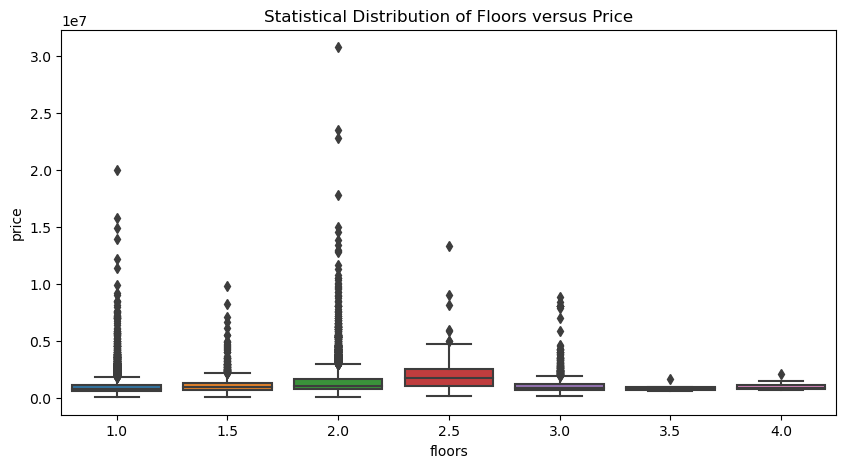

In [5]:
# Taking `floors` to have some visualization
plt.figure(figsize=(10,5))
sns.boxplot(x = df["floors"], y=df["price"])
plt.title("Statistical Distribution of Floors versus Price")

plt.savefig('../images/statistical_distribution_of_floors_versus_price.png')
plt.show()

Analysis of the data within the normal range is nearly impossible to interpret because of the price outliers. The grey diamonds are indicative of datapoints that deviate by three times the standard deviation in normally distributed data. If following the three sigma rule, this only accounts for 0.3% of the data, which seems negligible but can have disastrous effects on our model.

Let's take those outliers out. We'll use a combination of scipy's zscore() and numpy's abs() methods to identify and remove the outliers in price.

In [6]:
stats.zscore(df.price)

0       -0.486260
1       -0.215267
2       -0.888877
3       -0.375650
4       -0.577512
           ...   
29177    0.487101
29178    0.219427
29179   -0.347998
29180   -0.375650
29181   -0.679825
Name: price, Length: 29182, dtype: float64

In [7]:
df[stats.zscore(df.price) < 3]['price'].describe()

count    2.876500e+04
mean     1.044572e+06
std      6.046121e+05
min      2.736000e+04
25%      6.400000e+05
50%      8.600000e+05
75%      1.295000e+06
max      3.810000e+06
Name: price, dtype: float64

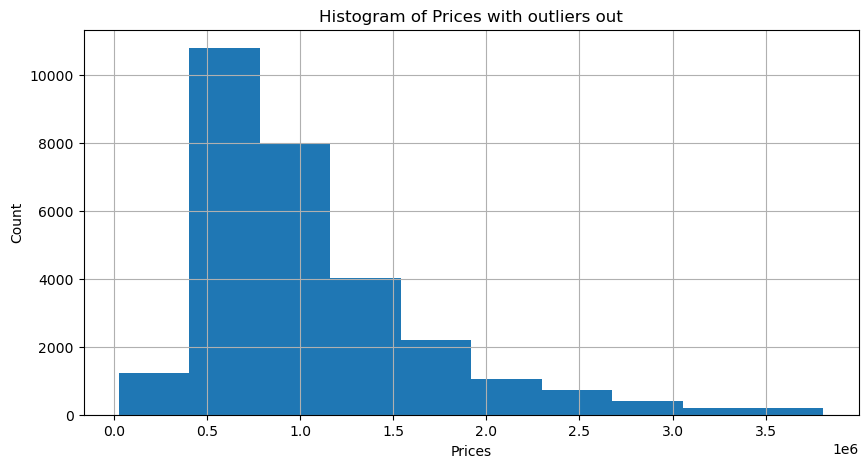

In [8]:
plt.figure(figsize=(10,5))
hist = df[stats.zscore(df.price) < 3]['price'].hist();
hist.set_title('Histogram of Prices with outliers out')
hist.set_xlabel('Prices')
hist.set_ylabel('Count')

plt.savefig('../images/histogram_of_prices_with_outliers_out.png')

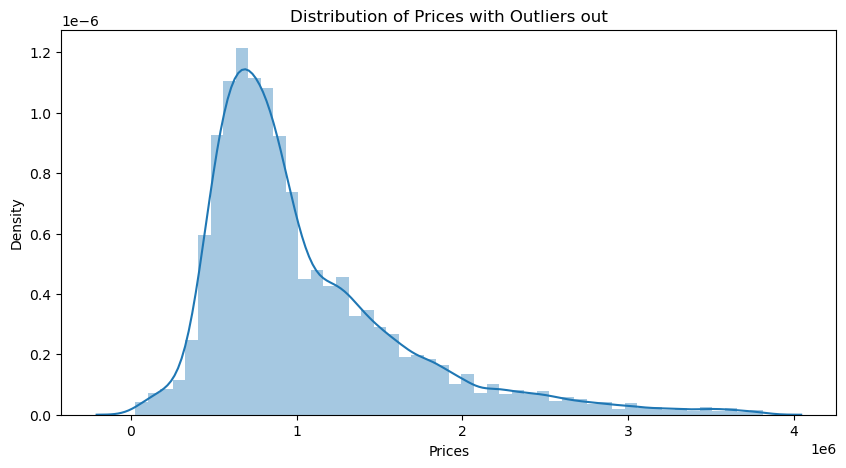

In [9]:
plt.figure(figsize=(10,5))
dist = sns.distplot(df[stats.zscore(df.price) < 3]['price'])
dist.set(title="Distribution of Prices with Outliers out", xlabel='Prices')

plt.savefig('../images/distribution_of_prices_with_outliers_out.png')

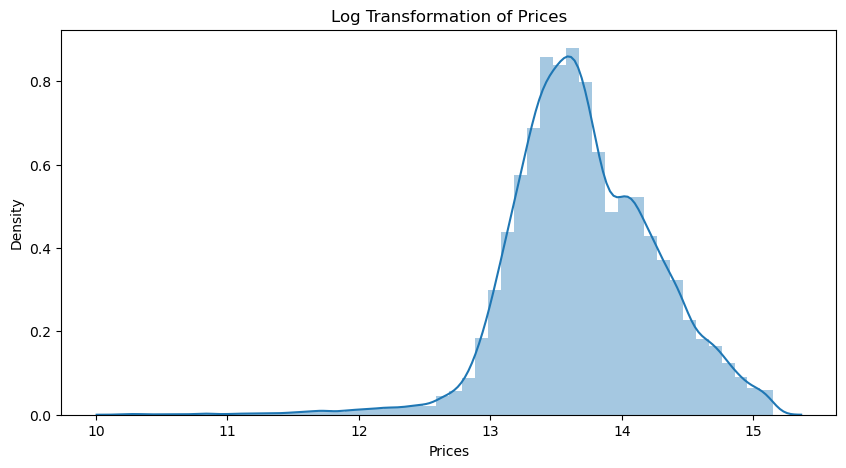

In [10]:
# Log transform to normalize our target variable, `price`
plt.figure(figsize=(10,5))
price_log = np.log(df[stats.zscore(df.price) < 3]['price'] )
sns.distplot(price_log).set(title="Log Transformation of Prices", xlabel='Prices')

plt.savefig('../images/log_transformation_of_prices.png');

In [11]:
# Run new model only considering the new dataset with outliers out.
no_outliers_df = df[(np.abs(stats.zscore(df.price)) < 3)]

In [12]:
# max price range moved from seven figures to six figures in price 
df['price'].describe()['min'], df['price'].describe()['max']

(27360.0, 30750000.0)

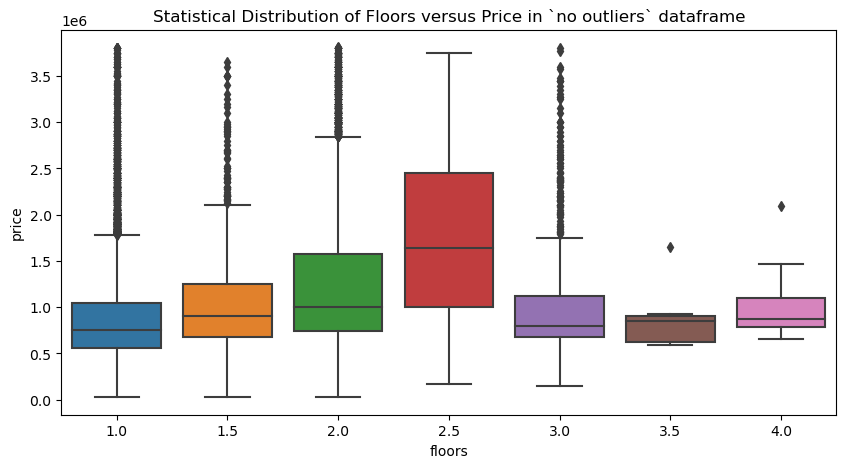

In [13]:
# Plot `floors` again with the new dataframe `no_outliers_df`
plt.figure(figsize=(10, 5))
box = sns.boxplot(x = no_outliers_df["floors"], y=no_outliers_df["price"])
plt.title("Statistical Distribution of Floors versus Price in `no outliers` dataframe")

plt.savefig('../images/statistical_distribution_of_floors_versus_price_in_no_outliers.png')
plt.show()

In [14]:
no_outliers_df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,lat,long,yr_old
count,2.876500e+04,28765.000000,28765.000000,28765.000000,2.876500e+04,28765.000000,28765.000000,28765.000000,28765.000000,28765.000000,28765.000000,28765.000000,28765.000000,28765.000000,28765.000000
mean,1.044572e+06,3.422805,2.305927,2092.708257,1.685154e+04,1.513506,1795.291257,471.645820,331.574518,211.293238,1973.704989,91.492995,47.532993,-122.177479,44.963671
std,6.046121e+05,0.968956,0.855206,903.684659,6.031327e+04,0.548715,827.781020,567.687231,280.808672,238.241223,31.638955,417.711404,0.283495,1.014671,30.979583
min,2.736000e+04,0.000000,0.000000,3.000000,4.020000e+02,1.000000,2.000000,0.000000,0.000000,0.000000,1900.000000,0.000000,40.266940,-124.211008,-1.000000
25%,6.400000e+05,3.000000,2.000000,1430.000000,5.000000e+03,1.000000,1190.000000,0.000000,0.000000,40.000000,1952.000000,0.000000,47.425990,-122.329215,18.000000
50%,8.600000e+05,3.000000,2.500000,1930.000000,7.500000e+03,1.500000,1565.000000,0.000000,400.000000,140.000000,1976.000000,0.000000,47.554900,-122.235640,43.000000
75%,1.295000e+06,4.000000,3.000000,2600.000000,1.056800e+04,2.000000,2260.000000,950.000000,510.000000,310.000000,2001.000000,0.000000,47.672280,-122.126370,66.000000
max,3.810000e+06,13.000000,10.500000,15360.000000,3.253932e+06,4.000000,12660.000000,4130.000000,3580.000000,4370.000000,2022.000000,2022.000000,47.789830,-76.193190,122.000000


Remember the ONE home that cost nearly \\$31 million, now the maximum price is about \\$3.8 millions

In [15]:
no_outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28765 entries, 0 to 29181
Data columns (total 26 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   selldate       28765 non-null  object 
 1   price          28765 non-null  float64
 2   bedrooms       28765 non-null  int64  
 3   bathrooms      28765 non-null  float64
 4   sqft_living    28765 non-null  int64  
 5   sqft_lot       28765 non-null  int64  
 6   floors         28765 non-null  float64
 7   waterfront     28765 non-null  object 
 8   greenbelt      28765 non-null  object 
 9   nuisance       28765 non-null  object 
 10  view           28765 non-null  object 
 11  condition      28765 non-null  object 
 12  grade          28765 non-null  object 
 13  heat_source    28765 non-null  object 
 14  sewer_system   28765 non-null  object 
 15  sqft_above     28765 non-null  int64  
 16  sqft_basement  28765 non-null  int64  
 17  sqft_garage    28765 non-null  int64  
 18  sqft_p

In [16]:
no_outliers_df.corr()['price'].abs().sort_values(ascending=False)

price            1.000000
sqft_living      0.638747
sqft_above       0.562054
bathrooms        0.500346
bedrooms         0.339751
sqft_patio       0.293653
sqft_garage      0.279186
floors           0.241129
sqft_basement    0.221057
lat              0.220177
yr_old           0.146805
yr_built         0.114079
sqft_lot         0.094041
yr_renovated     0.080980
long             0.006185
Name: price, dtype: float64

## Modeling

### Dummies Model

In [17]:
# Dummyfiying Categorical-String Variables
cat_columns = ["waterfront", "greenbelt", "nuisance", "view", "condition", "grade", "heat_source", "sewer_system", "city"]
dummies_df = pd.get_dummies(data=no_outliers_df, columns=cat_columns, drop_first=True)

In [18]:
dummies_df

,selldate,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,sqft_garage,...,city_Sammamish,city_SeaTac,city_Seattle,city_Shoreline,city_Skykomish,city_Snoqualmie,city_Tukwila,city_Vashon,city_Woodinville,city_Yarrow Point
0,2022-05-24,675000.0,4,1.0,1180,7140,1.0,1180,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2021-12-13,920000.0,5,2.5,2770,6703,1.0,1570,1570,0,...,0,0,1,0,0,0,0,0,0,0
2,2021-09-29,311000.0,6,2.0,2880,6156,1.0,1580,1580,0,...,0,0,1,0,0,0,0,0,0,0
3,2021-12-14,775000.0,3,3.0,2160,1400,2.0,1090,1070,200,...,0,0,1,0,0,0,0,0,0,0
4,2021-08-24,592500.0,2,2.0,1120,758,2.0,1120,550,550,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29177,2021-11-30,1555000.0,5,2.0,1910,4000,1.5,1600,1130,0,...,0,0,1,0,0,0,0,0,0,0
29178,2021-06-16,1313000.0,3,2.0,2020,5800,2.0,2020,0,0,...,0,0,1,0,0,0,0,0,0,0
29179,2022-05-27,800000.0,3,2.0,1620,3600,1.0,940,920,240,...,0,0,1,0,0,0,0,0,0,0
29180,2022-02-24,775000.0,3,2.5,2570,2889,2.0,1830,740,480,...,0,0,0,0,0,0,0,0,0,0


In [19]:
X = dummies_df.drop(labels=["selldate", "price", "address"], axis=1)
y = dummies_df["price"]

In [20]:
results = sm.OLS(y, sm.add_constant(X)).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.718
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     828.9
Date:                Wed, 03 May 2023   Prob (F-statistic):               0.00
Time:                        07:39:44   Log-Likelihood:            -4.0555e+05
No. Observations:               28765   AIC:                         8.113e+05
Df Residuals:                   28676   BIC:                         8.120e+05
Df Model:                          88                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [21]:
house_price_preds = results.predict()
predicted_mean_price = np.sqrt(((no_outliers_df['price'] - house_price_preds) ** 2).mean())
print('Predicted Mean Price =', f"${predicted_mean_price:,.0f}")

Predicted Mean Price = $321,176


* The model is statistically significant overall, with a F-statistic p-value well below 0.05
* The model explains about 71.7% of the variance in `price`.
* The p-value some of the features in the model are more than the acceptable alpha of 0.5. Those are candidates to drop.

In [22]:
# p-values
pvalues_df = pd.DataFrame(results.pvalues, columns=['p-value'])
pvalues_df['p < 0.05'] = pvalues_df['p-value'] < 0.05
pvalues_df

,p-value,p < 0.05
const,6.494331e-16,True
bedrooms,2.566418e-04,True
bathrooms,2.038952e-26,True
sqft_living,1.588751e-31,True
sqft_lot,2.905952e-38,True
...,...,...
city_Snoqualmie,2.295734e-04,True
city_Tukwila,8.596270e-01,False
city_Vashon,2.756796e-03,True
city_Woodinville,2.113240e-08,True


In [23]:
# features whose p-values are > 0.05, and are canditates to be dropped.
pvalues_df[pvalues_df['p < 0.05'] != True].index

Index(['yr_old', 'greenbelt_YES', 'grade_2 Substandard',
       'heat_source_Electricity/Solar', 'heat_source_Oil',
       'heat_source_Oil/Solar', 'heat_source_Other',
       'sewer_system_PRIVATE RESTRICTED', 'sewer_system_PUBLIC RESTRICTED',
       'city_Auburn', 'city_Baring', 'city_Black Diamond', 'city_Burien',
       'city_Carnation', 'city_Covington', 'city_Des Moines', 'city_Duvall',
       'city_Enumclaw', 'city_Federal Way', 'city_Kent', 'city_Maple Valley',
       'city_Normandy Park', 'city_Pacific', 'city_Ravensdale', 'city_Redondo',
       'city_Renton', 'city_SeaTac', 'city_Tukwila'],
      dtype='object')

### No p-values > 0.05  Model

In [24]:
# previous model
X.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'sqft_above', 'sqft_basement', 'sqft_garage', 'sqft_patio', 'yr_built',
       'yr_renovated', 'lat', 'long', 'yr_old', 'waterfront_YES',
       'greenbelt_YES', 'nuisance_YES', 'view_EXCELLENT', 'view_FAIR',
       'view_GOOD', 'view_NONE', 'condition_Fair', 'condition_Good',
       'condition_Poor', 'condition_Very Good', 'grade_11 Excellent',
       'grade_12 Luxury', 'grade_13 Mansion', 'grade_2 Substandard',
       'grade_3 Poor', 'grade_4 Low', 'grade_5 Fair', 'grade_6 Low Average',
       'grade_7 Average', 'grade_8 Good', 'grade_9 Better',
       'heat_source_Electricity/Solar', 'heat_source_Gas',
       'heat_source_Gas/Solar', 'heat_source_Oil', 'heat_source_Oil/Solar',
       'heat_source_Other', 'sewer_system_PRIVATE RESTRICTED',
       'sewer_system_PUBLIC', 'sewer_system_PUBLIC RESTRICTED', 'city_Auburn',
       'city_Baring', 'city_Bellevue', 'city_Black Diamond', 'city_Bothell',
       'city_Bur

In [25]:
# drop features whose p-values are > 0.05
to_drop = ['yr_old', 'greenbelt_YES', 'grade_2 Substandard',
       'heat_source_Electricity/Solar', 'heat_source_Oil',
       'heat_source_Oil/Solar', 'heat_source_Other',
       'sewer_system_PRIVATE RESTRICTED', 'sewer_system_PUBLIC RESTRICTED',
       'city_Auburn', 'city_Baring', 'city_Black Diamond', 'city_Burien',
       'city_Carnation', 'city_Covington', 'city_Des Moines', 'city_Duvall',
       'city_Enumclaw', 'city_Federal Way', 'city_Kent', 'city_Maple Valley',
       'city_Normandy Park', 'city_Pacific', 'city_Ravensdale', 'city_Redondo',
       'city_Renton', 'city_SeaTac', 'city_Tukwila']

In [26]:
X2 = X.drop(labels=to_drop, axis=1)

In [27]:
results2 = sm.OLS(y, sm.add_constant(X2)).fit()
print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.716
Model:                            OLS   Adj. R-squared:                  0.715
Method:                 Least Squares   F-statistic:                     1206.
Date:                Wed, 03 May 2023   Prob (F-statistic):               0.00
Time:                        07:39:45   Log-Likelihood:            -4.0564e+05
No. Observations:               28765   AIC:                         8.114e+05
Df Residuals:                   28704   BIC:                         8.119e+05
Df Model:                          60                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -8.487e+

In [28]:
house_price_preds = results2.predict()
predicted_mean_price = np.sqrt(((no_outliers_df['price'] - house_price_preds) ** 2).mean())
print('Predicted Mean Price =', f"${predicted_mean_price:,.0f}")

Predicted Mean Price = $322,239


* The model is statistically significant overall, with a F-statistic p-value well below 0.05
* The model explains about 71.7% of the variance in `price`.
* * The fact the R-squared doesn't change, means this model does not improve the previous one. 
* The p-value of the features are well under the acceptable 0.05.

## Assumptions

### Linearity

The dependent variable (y) is assume to be a function of the independent variables (X, features)

The desired outcome is that points are symmetrically distributed around a diagonal line in the `observed vs. predicted` plot or around a horizontal line in the `residuals vs. predicted`. In both cases with a roughly constant variance.

In [29]:
%config InlineBacked.figure_format = 'retina'
sns.set_style('darkgrid')
sns.mpl.rcParams['figure.figsize'] = (15.0, 9.0)

def linearity_test(model, y):
    '''
    Function for visually inspecting the assumptions of linearity in a linear regression models.
    '''
    
    fitted_vals = model.predict()
    resids = model.resid
    
    fig, ax = plt.subplots(1, 2)
    
    sns.regplot(x=fitted_vals, y=y, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Obeserved vs. Predicted Values')
    
    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Residuals vs. Predicted Values')
    
    plt.savefig('../images/assumption_linearity_03_outliers.png')
    

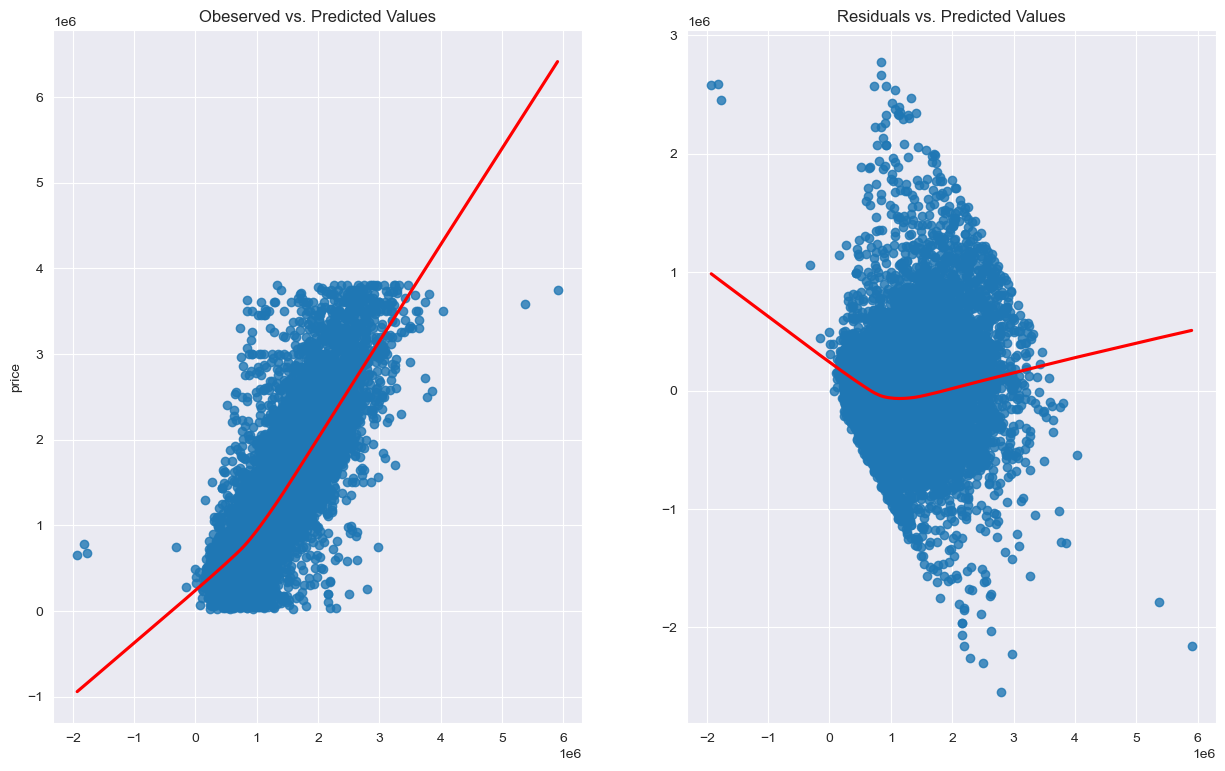

In [30]:
linearity_test(results2, y)

* A visual inspection of the plots shows that even the points look with some kind of symmetric they are cluster in a pocket of space instead of being displayed along the diagonal or horizontal lines.
* The linearity assumption is not satisfied

Potential solutions:
* non-linear transformations to dependent/independent variables
* adding extra features which are a transformation of the already used ones (for example squared version)
* adding features that were not considered before

### Expectation (mean) of residuals is zero

In [31]:
# Linear Regression Residuals
results2.resid.mean()

-2.267720871769292e-07

We can assume the expectation of residuals is zero.

### Multicollinearity

One scenario to watch out for is the ‘dummy variable trap’ — when we use dummy variables to encode a categorical feature and do not omit the baseline level from the model. This results in a perfect correlation between the dummy variables and the constant term.

* We can detect multicollinearity using the variance inflaction factor (VIF)
* If no features are correlated, then all values for VIF will be 1.

In [32]:
# From statsmodels import `variance inflation factor`
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [33]:
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X2.values, i) for i in range(X2.shape[1])]
vif["features"] = X2.columns
vif.round(1)

,VIF Factor,features
0,27.3,bedrooms
1,26.3,bathrooms
2,121.5,sqft_living
3,1.3,sqft_lot
4,20.4,floors
5,94.3,sqft_above
6,7.3,sqft_basement
7,5.1,sqft_garage
8,2.3,sqft_patio
9,9187.9,yr_built


* To deal with Multicolinearity as a rule of thumb we should remove features with VIF larger than 10 (5 is also common). 
* Another possible solution is to use PCA to reduce features to a smaller set of uncorrelated components.

### Homoscedasticity

To investigate if the residuals are homoscedastic, we can look at a plot of `residuals (or standardized residuals)` vs. `predicted (fitted) values`. What should alarm us is the case when the residuals grow either as a function of predicted value or time (in case of time series).

We can also use two statistical tests: `Breusch-Pagan` and `Goldfeld-Quandt`. In both of them, the null hypothesis assumes homoscedasticity and a p-value below a certain level (like 0.05) indicates we should reject the null in favor of heteroscedasticity.

In [34]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'
# import seaborn as sns 
# import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
sns.set_style('darkgrid')
sns.mpl.rcParams['figure.figsize'] = (15.0, 9.0)

def homoscedasticity_test(model):
    '''
    Function for testing the homoscedasticity of residuals in a linear regression model.
    It plots residuals and standardized residuals vs. fitted values and runs Breusch-Pagan and Goldfeld-Quandt tests.
    
    Args:
    * model - fitted OLS model from statsmodels
    '''
    fitted_vals = model.predict()
    resids = model.resid
    resids_standardized = model.get_influence().resid_studentized_internal

    fig, ax = plt.subplots(1,2)

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Residuals vs Fitted', fontsize=16)
    ax[0].set(xlabel='Fitted Values', ylabel='Residuals')

    sns.regplot(x=fitted_vals, y=np.sqrt(np.abs(resids_standardized)), lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Scale-Location', fontsize=16)
    ax[1].set(xlabel='Fitted Values', ylabel='sqrt(abs(Residuals))')

    bp_test = pd.DataFrame(sms.het_breuschpagan(resids, model.model.exog), 
                           columns=['value'],
                           index=['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value'])

    gq_test = pd.DataFrame(sms.het_goldfeldquandt(resids, model.model.exog)[:-1],
                           columns=['value'],
                           index=['F statistic', 'p-value'])

    print('\n Breusch-Pagan test ----')
    print(bp_test)
    print('\n Goldfeld-Quandt test ----')
    print(gq_test)
    print('\n\n Residuals plots ----')


 Breusch-Pagan test ----
                                     value
Lagrange multiplier statistic  2941.912432
p-value                           0.000000
f-value                          54.502038
f p-value                         0.000000

 Goldfeld-Quandt test ----
                value
F statistic  1.025971
p-value      0.062496


 Residuals plots ----


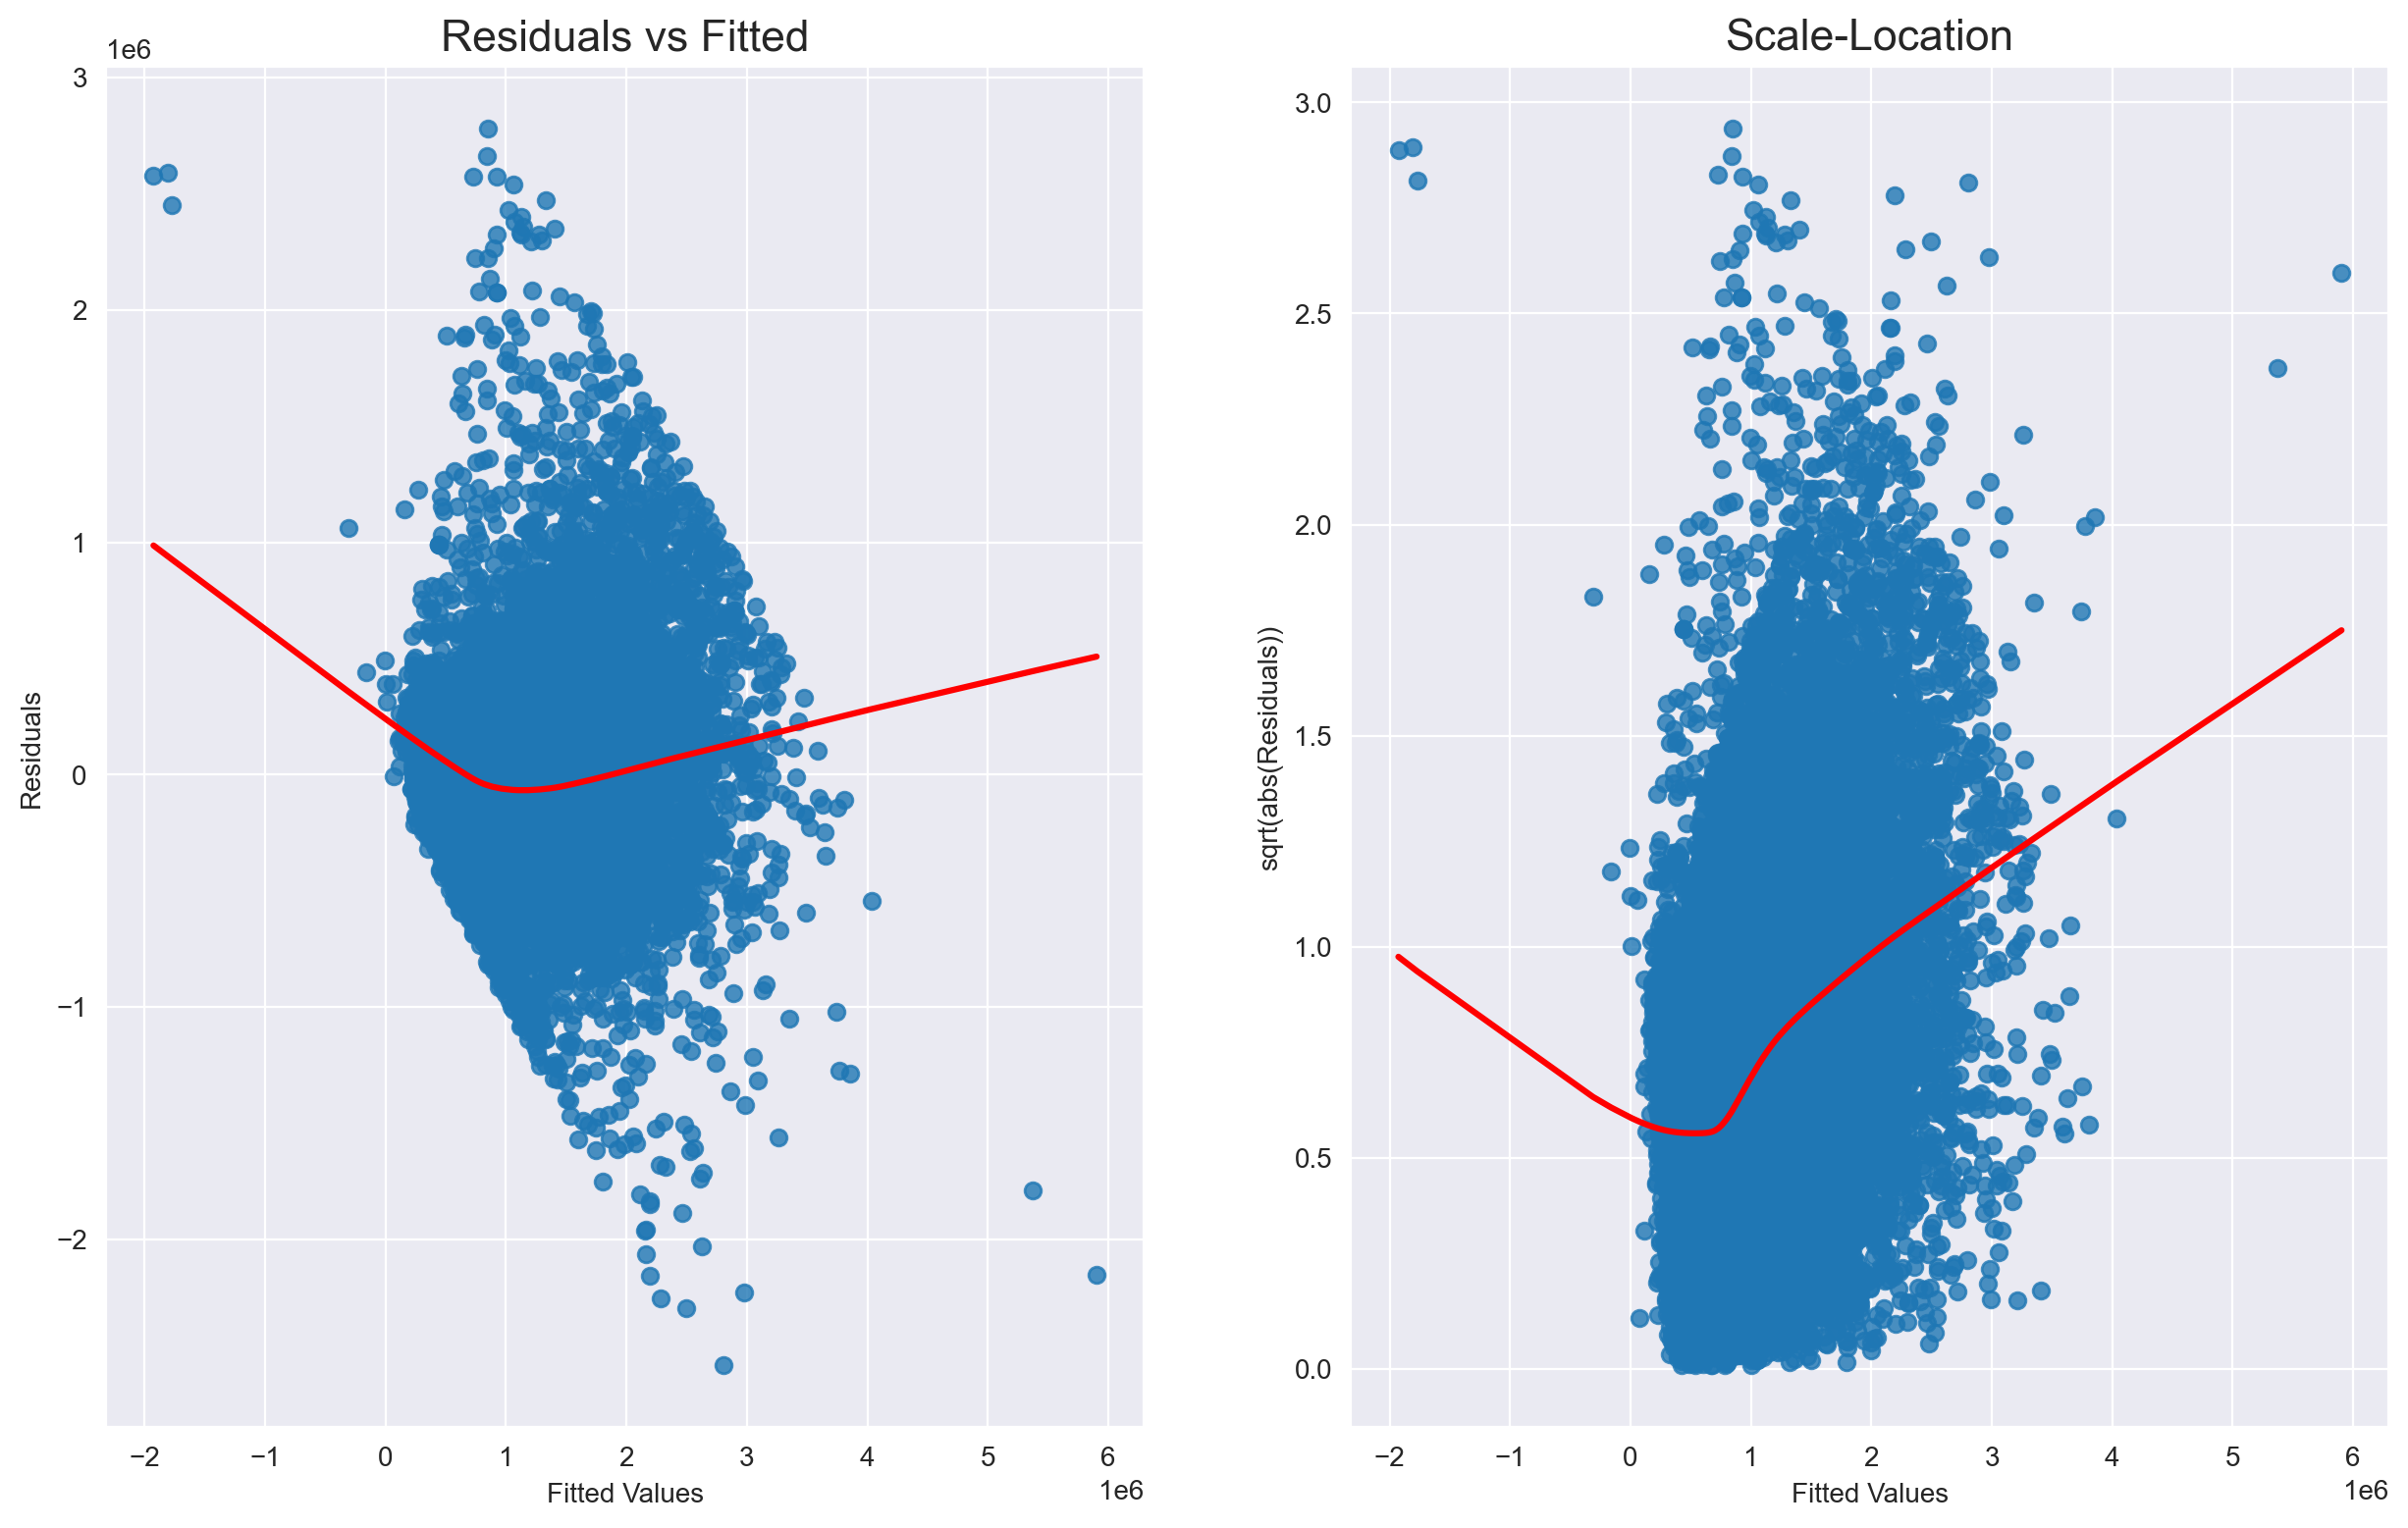

In [35]:
homoscedasticity_test(results2)

The results indicate that the assumption is not satisfied and we should reject the hypothesis of homoscedasticity.

Potential solutions:
* log transformation of the dependent variable

### No autocorrelation of residuals

Another reason for serial correlation in the residuals could be a violation of the linearity assumption or due to bias that is explainable by omitted variables (interaction terms or dummy variables for identifiable conditions). An example of the former case might be fitting a (straight) line to data, which exhibits exponential growth over time.

The test statistic provides a test for significant residual autocorrelation at lag 1. The Durbin-Watson (DW) statistic is approximately equal to 2(1-a), where a is the lag 1 residual autocorrelation.

Some notes on the Durbin-Watson test:
* the test statistic always has a value between 0 and 4
* value of 2 means that there is no autocorrelation in the sample
* values < 2 indicate positive autocorrelation, values > 2 negative one.

In [36]:
import statsmodels.tsa.api as smt

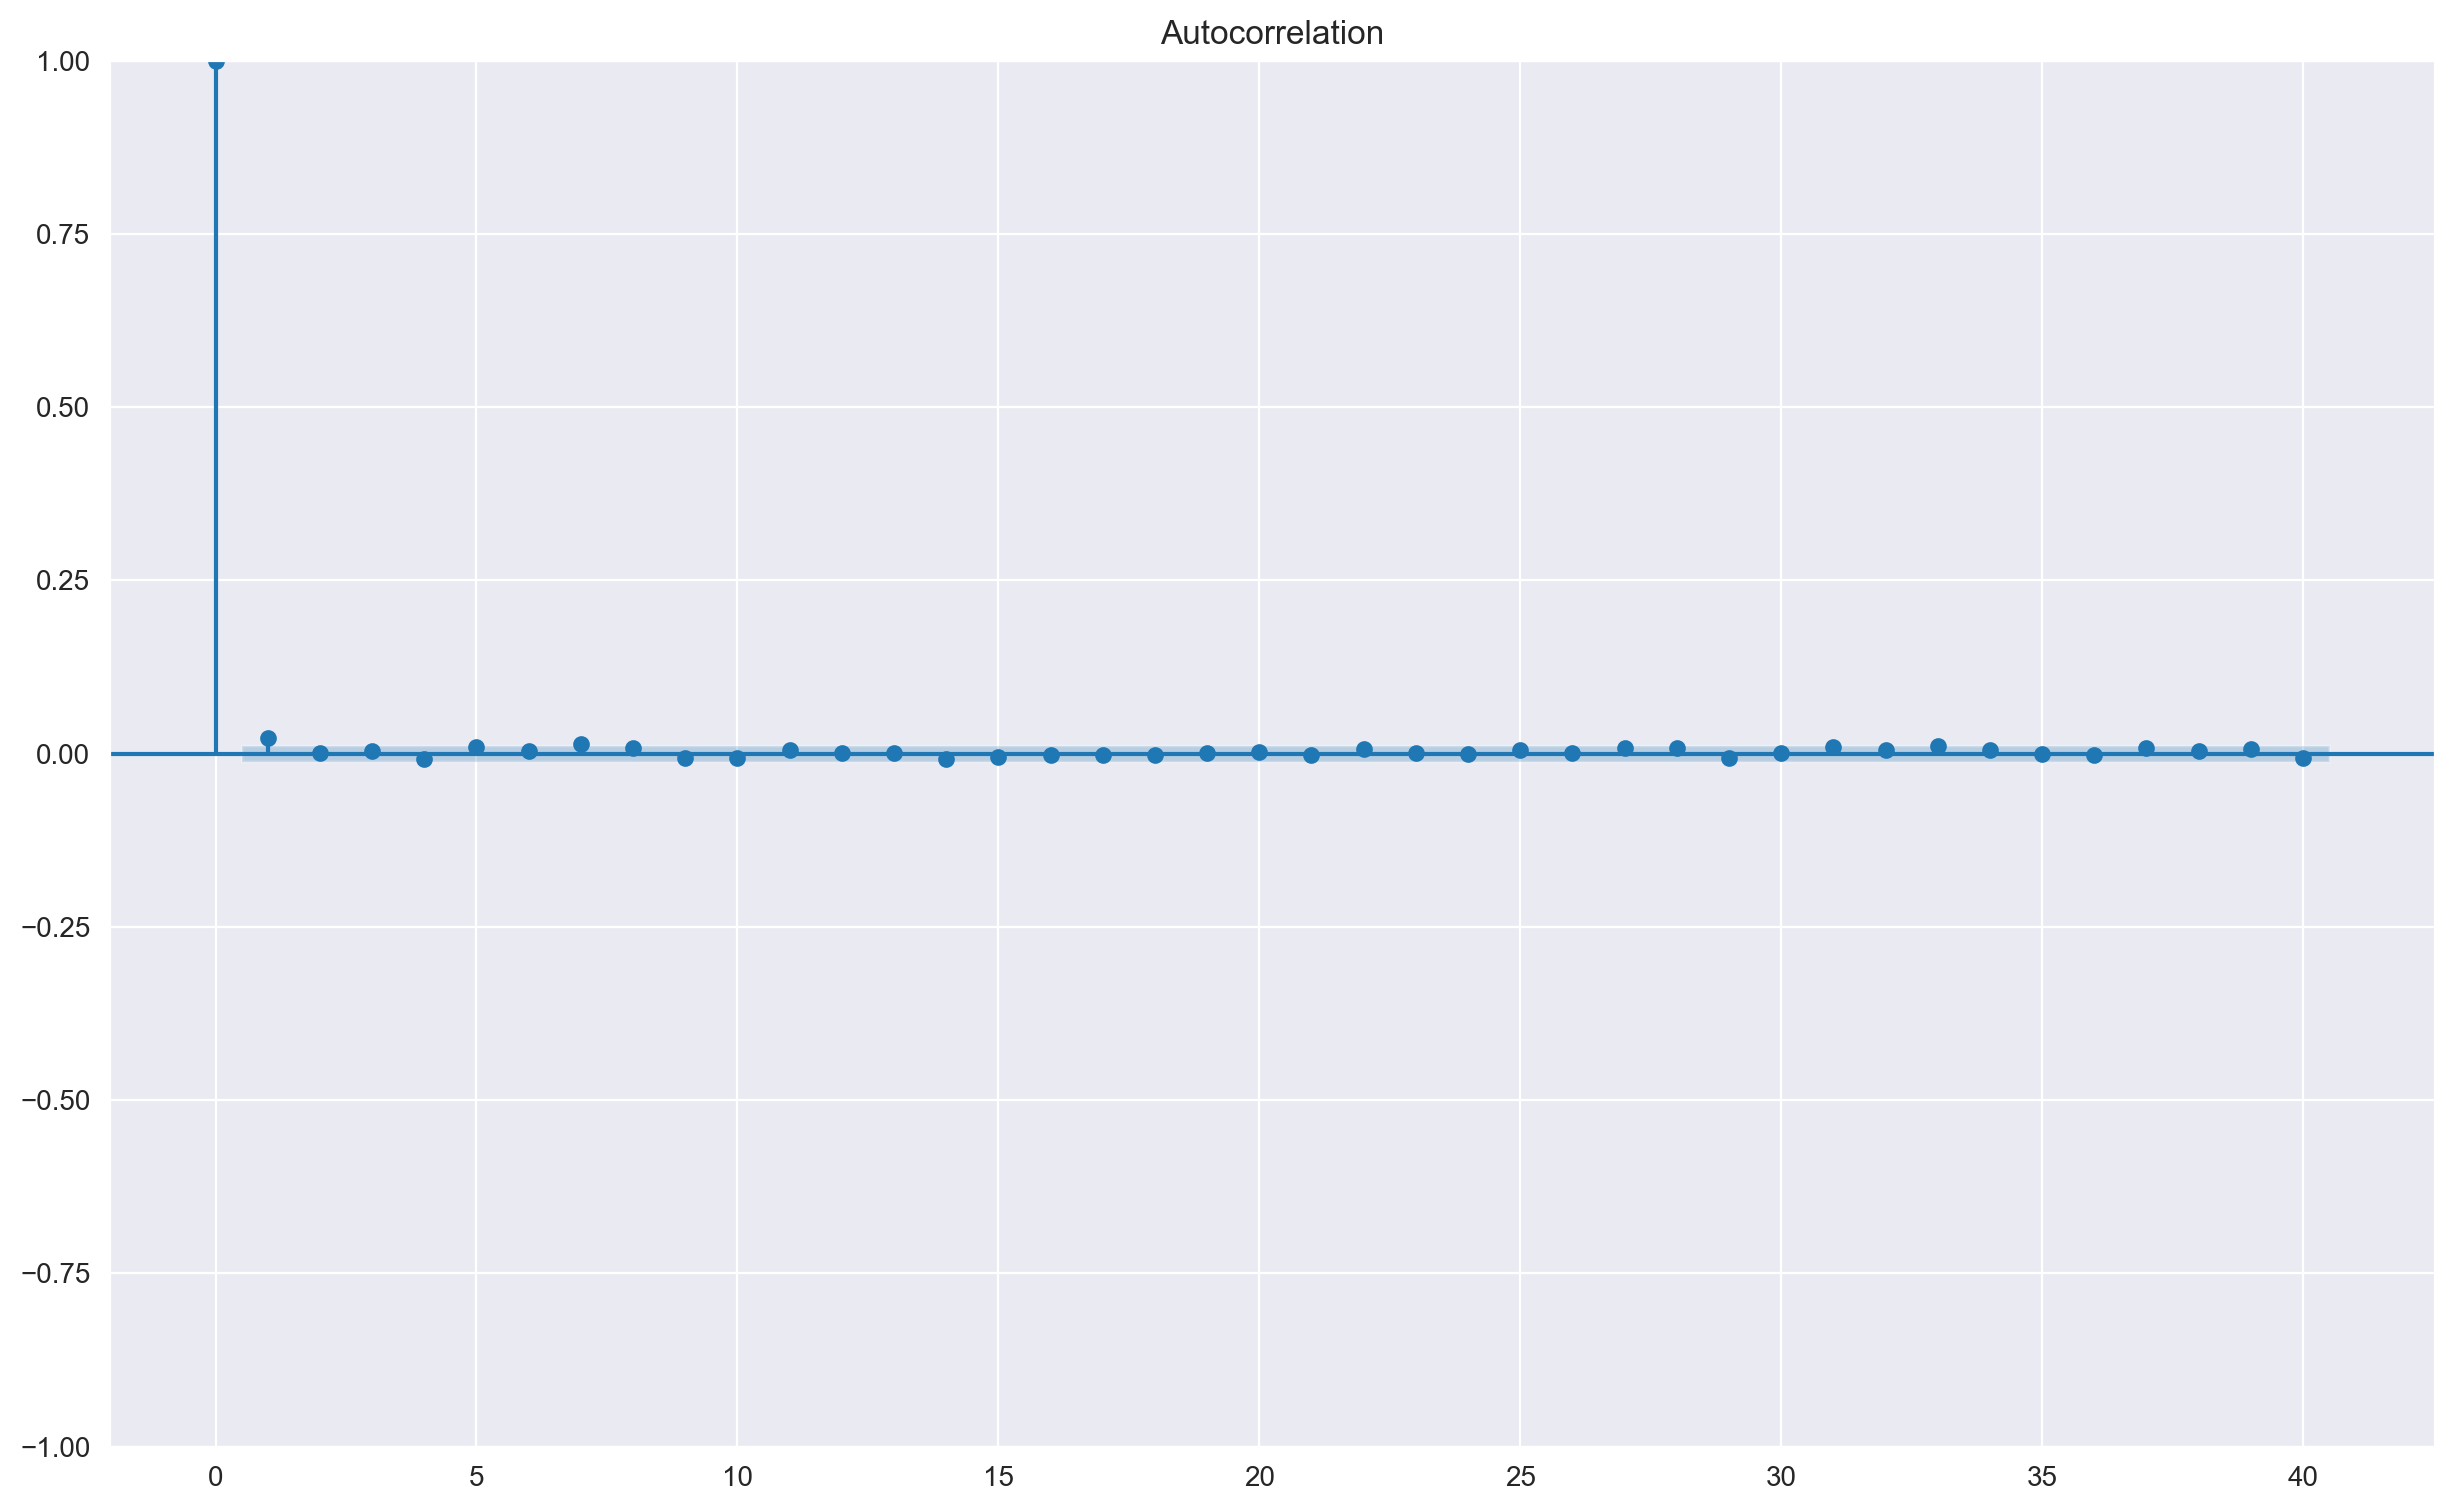

In [37]:
acf = smt.graphics.plot_acf(results2.resid, lags=40 , alpha=0.05)

plt.savefig('../images/autocorrelation_model2_durbin_watson_test.png')
acf.show();

Or, looking at the default summary output of the linear regression model:
* Durbin-Watson: 1.955
* DW < 2 means there is positive correlation between the features in the dataset.
* In this case the DW is close to 2, then, there might be some room for fine-tuning the model. For example, adding lags of the dependent/independent variables.

### Other Assumptions

#### The features and residuals are uncorrelated

* The features and residuals are uncorrelated.
* check the Pearson correlation coefficient between each feature and the residuals.
* Then report the p-value for testing the lack of correlation between the two considered series.

In [38]:
from scipy.stats.stats import pearsonr

In [39]:
for column in X2.columns:
    corr_test = pearsonr(X2[column], results2.resid)
    print(f'Variable: {column} --- correlation: {corr_test[0]:.4f}, p-value: {corr_test[1]:.4f}')

Variable: bedrooms --- correlation: 0.0000, p-value: 1.0000
Variable: bathrooms --- correlation: -0.0000, p-value: 1.0000
Variable: sqft_living --- correlation: -0.0000, p-value: 1.0000
Variable: sqft_lot --- correlation: -0.0000, p-value: 1.0000
Variable: floors --- correlation: -0.0000, p-value: 1.0000
Variable: sqft_above --- correlation: -0.0000, p-value: 1.0000
Variable: sqft_basement --- correlation: 0.0000, p-value: 1.0000
Variable: sqft_garage --- correlation: -0.0000, p-value: 1.0000
Variable: sqft_patio --- correlation: -0.0000, p-value: 1.0000
Variable: yr_built --- correlation: -0.0000, p-value: 1.0000
Variable: yr_renovated --- correlation: -0.0000, p-value: 1.0000
Variable: lat --- correlation: 0.0000, p-value: 1.0000
Variable: long --- correlation: -0.0000, p-value: 1.0000
Variable: waterfront_YES --- correlation: -0.0000, p-value: 1.0000
Variable: nuisance_YES --- correlation: -0.0000, p-value: 1.0000
Variable: view_EXCELLENT --- correlation: -0.0000, p-value: 1.0000
Va

Cannot reject the null hypothesis (lack of correlation) for any pair.

#### The number of observations must be greater than the number of features

In [40]:
obs = df.shape[0]
features = len(df.columns)
if obs > features:
    print('Number of observations is greater than number of features')
else:
    print('Number of observations is less than number of features')

Number of observations is greater than number of features


#### There must be some variability in features

In [41]:
# Checking variance of all the features for the model
X2.apply(np.var, axis=0)

bedrooms                 9.388437e-01
bathrooms                7.313520e-01
sqft_living              8.166176e+05
sqft_lot                 3.637564e+09
floors                   3.010778e-01
sqft_above               6.851976e+05
sqft_basement            3.222576e+05
sqft_garage              7.885077e+04
sqft_patio               5.675691e+04
yr_built                 1.000989e+03
yr_renovated             1.744768e+05
lat                      8.036654e-02
long                     1.029522e+00
waterfront_YES           1.394894e-02
nuisance_YES             1.413282e-01
view_EXCELLENT           1.492757e-02
view_FAIR                6.938831e-03
view_GOOD                2.782533e-02
view_NONE                1.012666e-01
condition_Fair           7.692376e-03
condition_Good           2.001484e-01
condition_Poor           2.081517e-03
condition_Very Good      9.943765e-02
grade_11 Excellent       9.605211e-03
grade_12 Luxury          2.081517e-03
grade_13 Mansion         1.390385e-04
grade_3 Poor

There are features whose variance is more than `near zero`

#### Normality of residuals

When this assumption is violated, it causes problems with calculating confidence intervals and various significance tests for coefficients. When the error distribution significantly departs from Gaussian, confidence intervals may be too wide or too narrow.

Some of the potential reasons causing non-normal residuals:
* presence of a few large outliers in data
* there might be some other problems (violations) with the model assumptions
* another, better model specification might be better suited for this problem

To investigate this assumption we can look at:
* `QQ` plots of the residuals (a detailed description can be found here). For example, a bow-shaped pattern of deviations from the diagonal implies that the residuals have excessive skewness (i.e., the distribution is not symmetrical, with too many large residuals in one direction). The s-shaped pattern of deviations implies excessive kurtosis of the residuals — there are either too many or two few large errors in both directions.
* use statistical tests such as the `Kolmogorov-Smirnov` test, the `Shapiro-Wilk` test, the `Jarque-Bera` test, and the `Anderson-Darling` test

In [42]:
def normality_of_residuals_test(model):
    '''
    Function for drawing the normal QQ-plot of the residuals and running 4 statistical tests to 
    investigate the normality of residuals.
    
    Arg:
    * model - fitted OLS models from statsmodels
    '''
    sm.ProbPlot(model.resid).qqplot(line='s');
    plt.title('Q-Q plot');
    plt.legend(['Actual','Theoretical']);
    plt.savefig('../images/qq_model_4.png')

    jb = stats.jarque_bera(model.resid)
    sw = stats.shapiro(model.resid)
    ad = stats.anderson(model.resid, dist='norm')
    ks = stats.kstest(model.resid, 'norm')
    
    print(f'Jarque-Bera test ---- statistic: {jb[0]:.4f}, p-value: {jb[1]}')
    print(f'Shapiro-Wilk test ---- statistic: {sw[0]:.4f}, p-value: {sw[1]:.4f}')
    print(f'Kolmogorov-Smirnov test ---- statistic: {ks.statistic:.4f}, p-value: {ks.pvalue:.4f}')
    print(f'Anderson-Darling test ---- statistic: {ad.statistic:.4f}, 5% critical value: {ad.critical_values[2]:.4f}')
    print('\nIf the returned AD statistic is larger than the critical value, then for the 5% significance level, the null hypothesis that the data come from the Normal distribution should be rejected. ')
    

Jarque-Bera test ---- statistic: 76907.1599, p-value: 0.0
Shapiro-Wilk test ---- statistic: 0.9045, p-value: 0.0000
Kolmogorov-Smirnov test ---- statistic: 0.5178, p-value: 0.0000
Anderson-Darling test ---- statistic: 537.5586, 5% critical value: 0.7870

If the returned AD statistic is larger than the critical value, then for the 5% significance level, the null hypothesis that the data come from the Normal distribution should be rejected. 


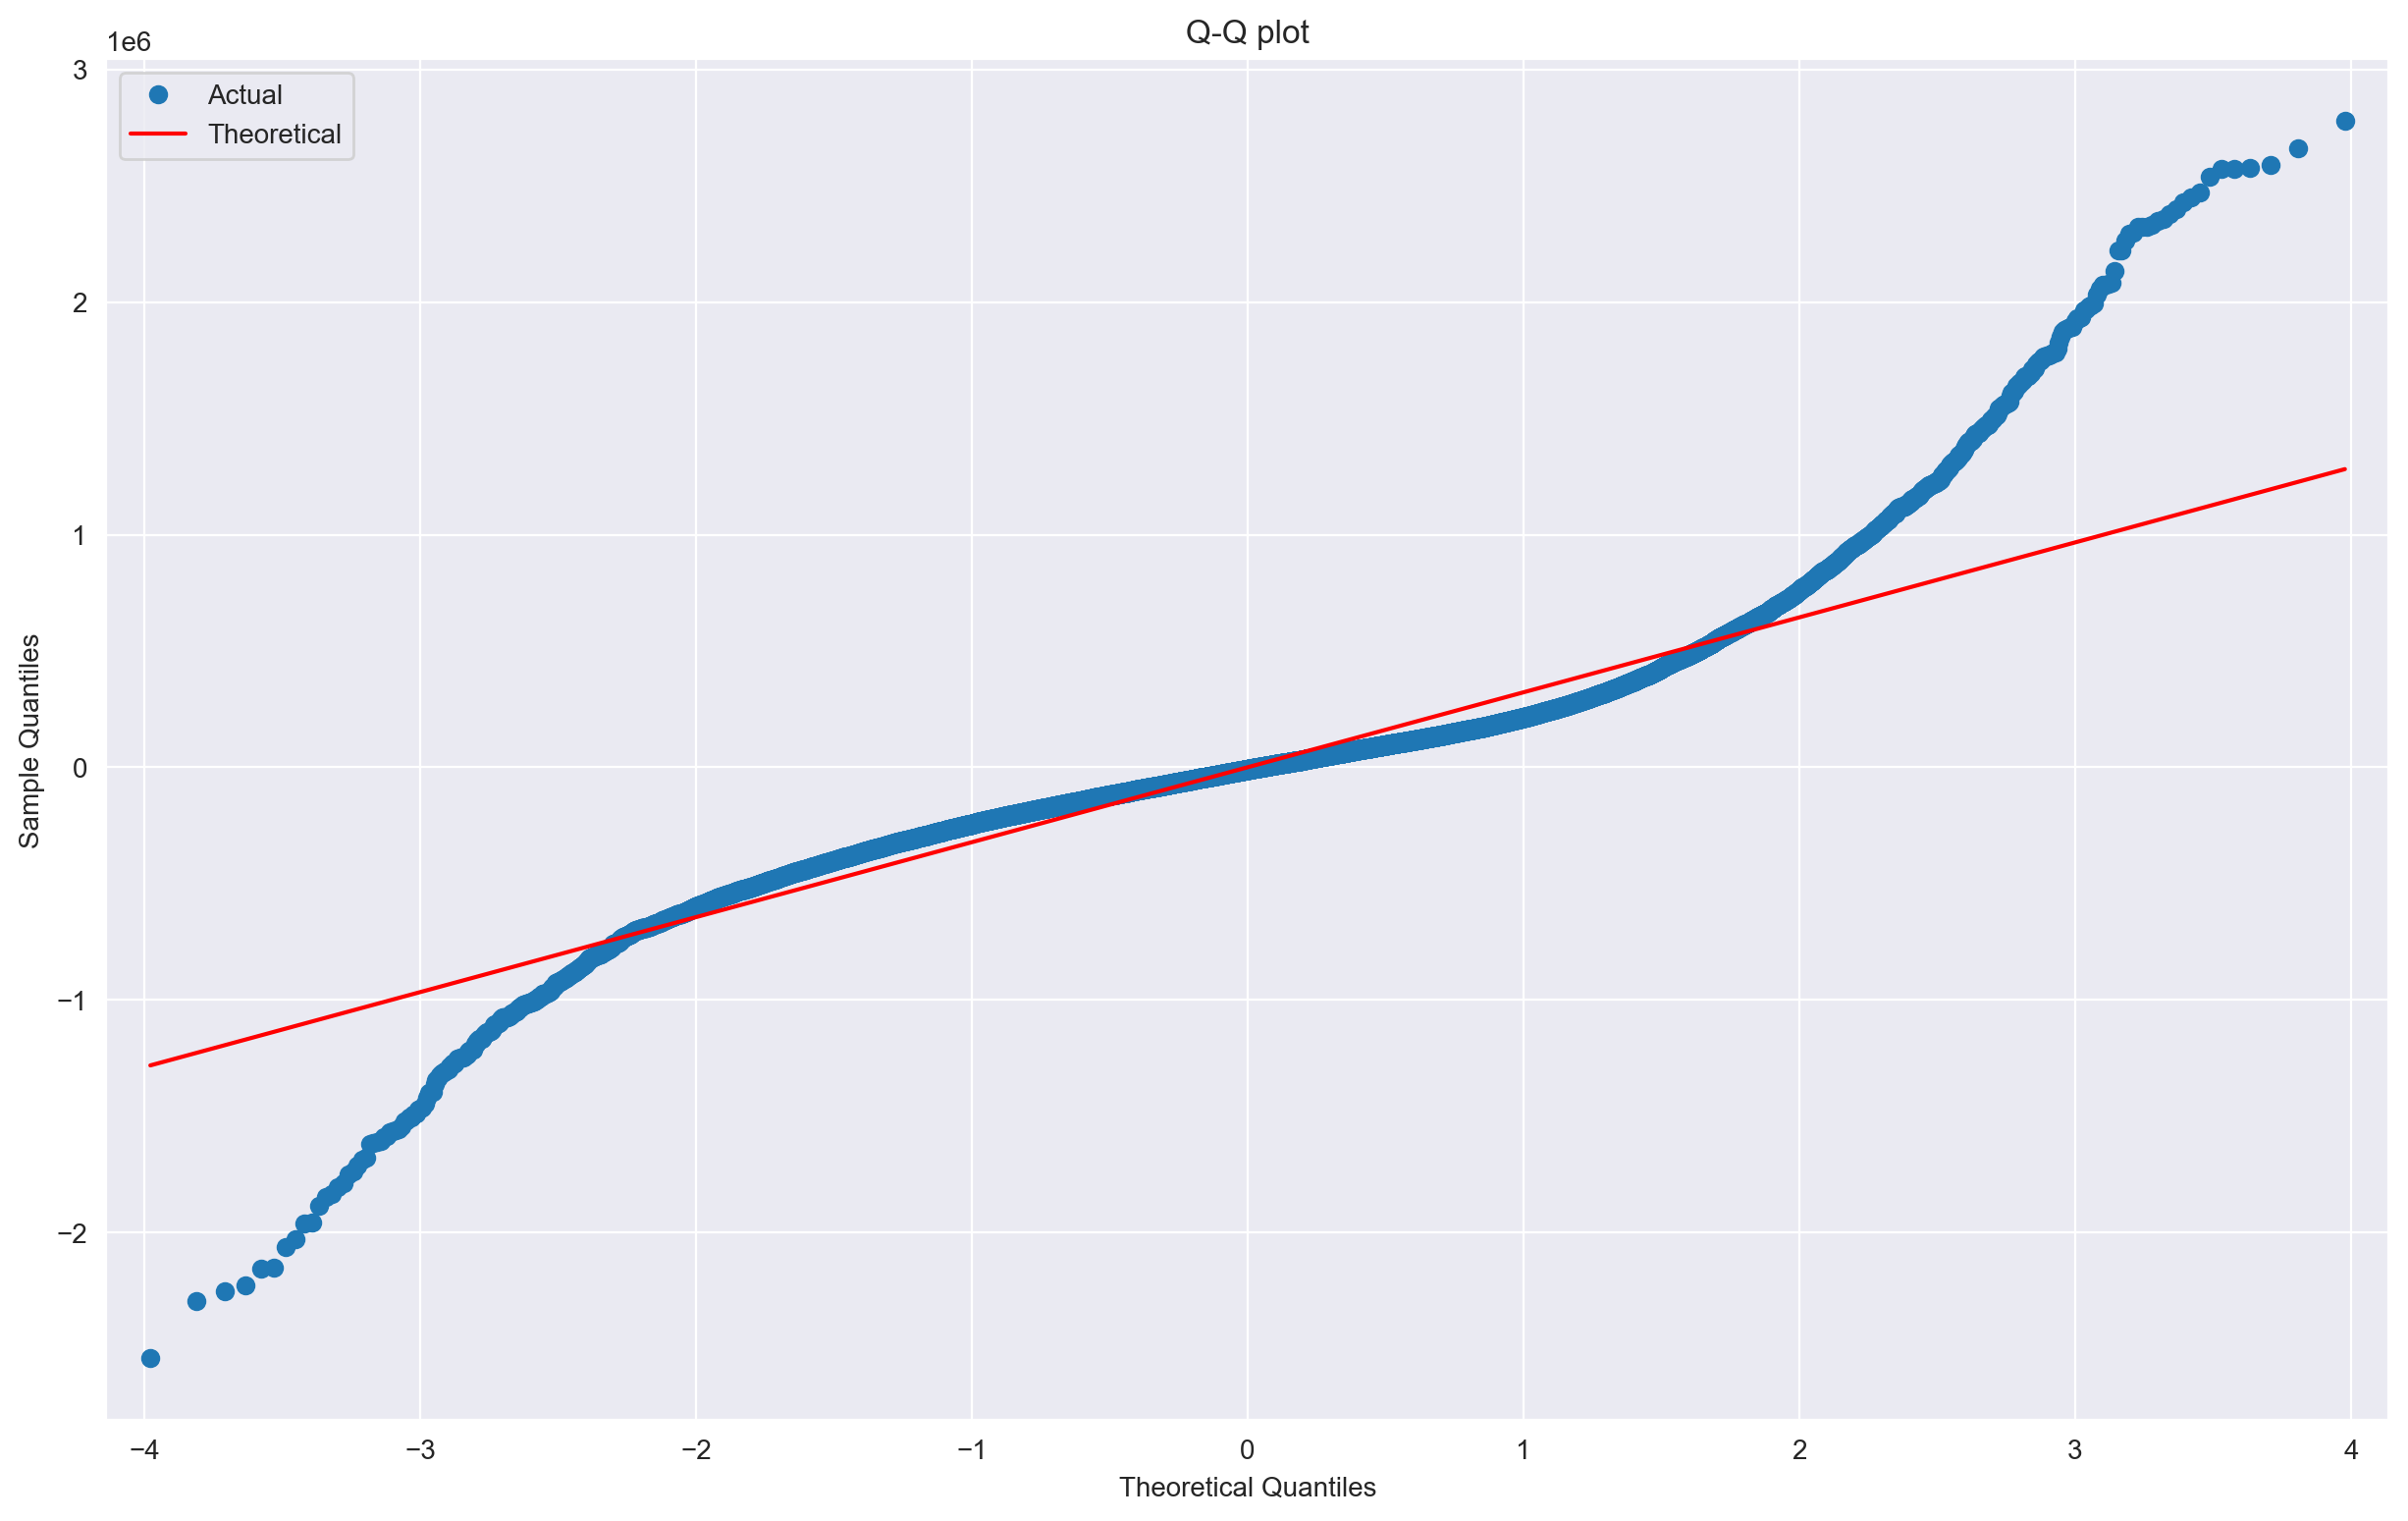

In [43]:
normality_of_residuals_test(results2)

Potential solutions:
* nonlinear transformation of target variable or features
* remove/treat potential outliers
* it can happen that there are two or more subsets of the data having different statistical properties, in which case separate models might be considered

## Save for later use

In [44]:
df.to_csv('../data/03_outliers.csv', index=False)
X2.to_csv('../data/03_model.csv', index=False)